# 2 Evaluation of the Optimal ANN on Season 5 Data

This notebook focuses on the assessment of the optimal ANN configuration, which was identified based on its performance with season 4 data. The evaluation is extended to a newly acquired dataset from season 5. The parameters defining this optimal configuration are detailed in the sections below.

In [1]:
# Model A010
PREPROCESSING = "anderson"
SET_SPLIT = "mishra_with_outliers"
TRAINING_ORDER = "mishra"
TRAINING_DATASET = "train"
INCLUDE_MISHRA_OUTLIERS = True
X_SCALED = True

## 1.0 Setup

In [2]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from utils import models
from utils import evaluation

In [3]:
# set random seeds for Python, NumPy, and TensorFlow
seed_value = 42
os.environ["PYTHONHASHSEED"] = "0"
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

params = {
    "preprocessing": PREPROCESSING,
    "set_split": SET_SPLIT,
    "training_order": TRAINING_ORDER,
    "include_mishra_outliers": INCLUDE_MISHRA_OUTLIERS,
    "x_scaled": X_SCALED,
}

### 1.1 Prepare Dataset

In [4]:
# prepare data based on set parameters above

# read in data that has been preprocessed
if PREPROCESSING == "anderson":
    data_file = "data/input/season_1_to_4/anderson&etal_2020_pretreatment.csv"
    data_file_2 = "data/input/season_5/anderson&etal_2020_pretreatment.csv"
elif PREPROCESSING == "mishra":
    data_file = "data/input/season_1_to_4/mishra&passos_2021_pretreatment.csv"
    data_file_2 = "data/input/season_5/mishra&passos_2021_pretreatment.csv"
elif PREPROCESSING == "mishra_adj":
    data_file = "data/input/season_1_to_4/mishra&passos_2021_pretreatment_adjusted.csv"
    data_file_2 = "data/input/season_5/mishra&passos_2021_pretreatment_adjusted.csv"
elif PREPROCESSING == "raw":
    data_file = "data/input/season_1_to_4/nil_pretreatment.csv"
    data_file_2 = "data/input/season_5/mishra&nil_pretreatment.csv"
else:
    raise Exception("choose a valid preprocessing")
test_data = pd.read_csv(data_file_2).drop(columns=["Unnamed: 0"])
data = pd.read_csv(data_file).drop(columns=["Unnamed: 0"])
data.insert(0, "sample_order", 0)
data.insert(1, "sample_no", 0)
data.insert(2, "set", 0)

# include or exclude mishra outliers
if not INCLUDE_MISHRA_OUTLIERS:
    data = data.query("set_mishra != 'Outlier'").copy()

# assign set split
if SET_SPLIT == "anderson":
    data["sample_no"] = data["sample_no_anderson"]
    data["set"] = data["set_anderson"]
elif SET_SPLIT == "mishra" and not INCLUDE_MISHRA_OUTLIERS:
    data["sample_no"] = data["sample_no_mishra"]
    data["set"] = data["set_mishra"]
elif SET_SPLIT == "mishra_with_outliers" and INCLUDE_MISHRA_OUTLIERS:
    data["sample_no"] = data["sample_no_mishra_with_outliers"]
    data["set"] = data["set_mishra_with_outliers"]
else:
    raise Exception("choose a valid set split")

# order data based on ordering selection
if TRAINING_ORDER == "mishra" and SET_SPLIT == "mishra_with_outliers":
    TRAINING_ORDER = "mishra_with_outliers"
elif TRAINING_ORDER == "mishra_with_outliers" and SET_SPLIT == "mishra":
    TRAINING_ORDER = "mishra"
data.sort_values(by=f"sample_no_{TRAINING_ORDER}", inplace=True)
data.reset_index(inplace=True, drop=True)
data["sample_order"] = data.index + 1

data.groupby(["category", "set"]).size()

category  set    
Test      Val Ext    1448
Train     Cal        6861
          Tuning     3382
dtype: int64

In [5]:
data

,sample_order,sample_no,set,category,sample_no_anderson,set_anderson,sample_no_mishra,set_mishra,sample_no_mishra_with_outliers,set_mishra_with_outliers,...,963_savgol_w17_p2_d2,966_savgol_w17_p2_d2,969_savgol_w17_p2_d2,972_savgol_w17_p2_d2,975_savgol_w17_p2_d2,978_savgol_w17_p2_d2,981_savgol_w17_p2_d2,984_savgol_w17_p2_d2,987_savgol_w17_p2_d2,990_savgol_w17_p2_d2
0,1,1,Cal,Train,4056,Cal,1,Cal,1,Cal,...,-0.002065,-0.002108,-0.002036,-0.001879,-0.001669,-0.001439,-0.001229,-0.001061,-0.000932,-0.000850
1,2,2,Cal,Train,4504,Cal,2,Cal,2,Cal,...,-0.001721,-0.001758,-0.001707,-0.001585,-0.001409,-0.001224,-0.001061,-0.000910,-0.000806,-0.000725
2,3,3,Cal,Train,1244,Cal,3,Cal,3,Cal,...,-0.001965,-0.002023,-0.001960,-0.001847,-0.001671,-0.001461,-0.001262,-0.001108,-0.000987,-0.000902
3,4,4,Cal,Train,5131,Cal,4,Cal,4,Cal,...,-0.002025,-0.002089,-0.002040,-0.001904,-0.001714,-0.001505,-0.001316,-0.001169,-0.001065,-0.000987
4,5,5,Cal,Train,9210,Tuning,0,Outlier,5,Cal,...,-0.002218,-0.002279,-0.002219,-0.002071,-0.001851,-0.001611,-0.001389,-0.001198,-0.001076,-0.000977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11686,11687,11687,Val Ext,Test,11687,Val Ext,11358,Val Ext,11687,Val Ext,...,-0.002645,-0.002787,-0.002773,-0.002640,-0.002404,-0.002122,-0.001846,-0.001602,-0.001428,-0.001283
11687,11688,11688,Val Ext,Test,11688,Val Ext,11359,Val Ext,11688,Val Ext,...,-0.002615,-0.002767,-0.002768,-0.002634,-0.002390,-0.002106,-0.001834,-0.001601,-0.001431,-0.001297
11688,11689,11689,Val Ext,Test,11689,Val Ext,11360,Val Ext,11689,Val Ext,...,-0.002630,-0.002780,-0.002772,-0.002638,-0.002401,-0.002122,-0.001849,-0.001619,-0.001447,-0.001302
11689,11690,11690,Val Ext,Test,11690,Val Ext,11361,Val Ext,11690,Val Ext,...,-0.002646,-0.002803,-0.002802,-0.002685,-0.002462,-0.002174,-0.001898,-0.001659,-0.001478,-0.001331


In [6]:
# split into train and test
dfs = {
    "train": data.query("set.isin(['Cal', 'Tuning'])").copy(),
    "cal": data.query("set == 'Cal'").copy(),
    "tune": data.query("set == 'Tuning'").copy(),
    # "test": data.query("set == 'Val Ext'").copy()
    "test": test_data.copy()
}

d = {}

# get the x columns by getting columns that start with int
x_cols = data.filter(regex="^\d+", axis=1).columns.tolist()
if PREPROCESSING == "raw":
    x_cols = [c for c in x_cols if "absorbance" in c]

# convert to numpy arrays
for s in ("train", "cal", "tune", "test"):
    d[f"y_{s}"] = dfs[s]["dm"].to_numpy().reshape(-1, 1)
    d[f"x_{s}_raw"] = dfs[s][x_cols].to_numpy()
    print(f"""
    {s} set:
        X = {d[f"x_{s}_raw"].shape}
        Y = {d[f"y_{s}"].shape}"""
    )


    train set:
        X = (10243, 103)
        Y = (10243, 1)

    cal set:
        X = (6861, 103)
        Y = (6861, 1)

    tune set:
        X = (3382, 103)
        Y = (3382, 1)

    test set:
        X = (320, 103)
        Y = (320, 1)


### 1.2 Standardise Data

In [7]:
# train scaler using the entire training set
scaler = StandardScaler()
scaler.fit(X=d["x_train_raw"])

# apply scalar to training and test set
for s in ("train", "cal", "tune", "test"):
    d[f"x_{s}_scaled"] = scaler.transform(d[f"x_{s}_raw"])
    d[f"x_{s}"] = d[f"x_{s}_scaled"] if X_SCALED else d[f"x_{s}_raw"]

## 2.0 Build Models

### 2.2 ANN Anderson et al. (2020)

Epoch 1/10000
81/81 [==============================] - 1s 2ms/step - loss: 198.3663 - mse: 198.3663 - lr: 0.0050
Epoch 2/10000
81/81 [==============================] - 0s 1ms/step - loss: 144.4581 - mse: 144.4581 - lr: 0.0050
Epoch 3/10000
81/81 [==============================] - 0s 1000us/step - loss: 98.3457 - mse: 98.3457 - lr: 0.0050
Epoch 4/10000
81/81 [==============================] - 0s 947us/step - loss: 62.6225 - mse: 62.6225 - lr: 0.0050
Epoch 5/10000
81/81 [==============================] - 0s 953us/step - loss: 38.0016 - mse: 38.0016 - lr: 0.0050
Epoch 6/10000
81/81 [==============================] - 0s 972us/step - loss: 21.6026 - mse: 21.6026 - lr: 0.0050
Epoch 7/10000
81/81 [==============================] - 0s 958us/step - loss: 12.0641 - mse: 12.0641 - lr: 0.0050
Epoch 8/10000
81/81 [==============================] - 0s 1ms/step - loss: 6.9567 - mse: 6.9567 - lr: 0.0050
Epoch 9/10000
81/81 [==============================] - 0s 1ms/step - loss: 3.8730 - mse: 3.8730 - l

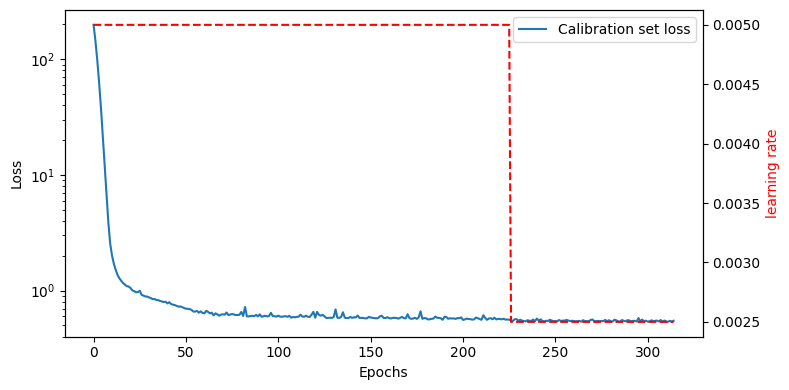

In [9]:
if TRAINING_DATASET == "train":
    model_ann, meta_ann = models.build_ann(
        x_train=d["x_train"],
        y_train=d["y_train"],
    )
else:
    model_ann, meta_ann = models.build_ann(
        x_train=d["x_cal"],
        y_train=d[f"y_cal"],
        x_val=d["x_tune"],
        y_val=d["y_tune"],
    )

## 3.0 Test model on new populations

10/10 [==============================] - 0s 1ms/step


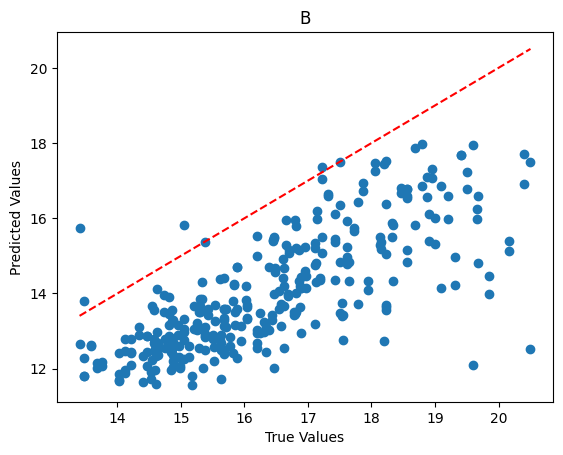

In [10]:
df = pd.DataFrame(
    data={
        "y_true": d[f"y_test"].flatten(),
        "y_pred": model_ann.predict(d[f"x_test"]).flatten(),
    }
)

# calculate r-squared value
r2 = r2_score(df["y_true"], df["y_pred"])

# create a scatter plot
plt.scatter(df["y_true"], df["y_pred"], label=f"R2 = {r2:.2f}")
plt.plot([min(df["y_true"]), max(df["y_true"])], [min(df["y_true"]), max(df["y_true"])], linestyle='--', color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("B")
plt.show()

In [11]:
df

,y_true,y_pred
0,19.20653,16.599030
1,19.20653,15.983841
2,19.00393,15.308704
3,19.00393,15.997675
4,16.89858,14.144005
...,...,...
315,14.55153,12.229719
316,14.88015,12.619537
317,14.88015,12.201906
318,14.60877,12.327871
